In [4]:
import os

import clean
import matplotlib.pyplot as plt
import numpy as np

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers

In [5]:
splits = clean.get_time_splits()
i_train, i_tune, i_test, t_train, t_tune, t_test = (
    splits[part]
    for part in ["i_train", "i_tune", "i_test", "t_train", "t_tune", "t_test"]
)

In [7]:
keras.utils.set_random_seed(42)

input_norm = layers.Normalization(
    axis=-1, mean=i_train.mean(axis=0), variance=i_train.var(axis=0)
)
output_denorm = layers.Normalization(
    axis=-1,
    invert=True,
    mean=t_train.mean(axis=0),
    variance=t_train.var(axis=0),
)

model = keras.Sequential(
    [
        layers.Input((12,), batch_size=50),
        input_norm,
        layers.Dense(12, activation="relu", name="layer1"),
        layers.Dense(1, name="layer2"),
        output_denorm,
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.losses.MeanAbsolutePercentageError()],
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (50, 12)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (50, 12)               │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (50, 1)                │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (50, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
keras.utils.set_random_seed(42)

history = model.fit(
    i_train,
    t_train,
    batch_size=500,
    epochs=30,
    validation_data=(i_tune, t_tune),
    # callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True)],
)

Epoch 1/30
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 21s 812us/step - loss: 400.0667 - mean_absolute_percentage_error: 874191.3750 - val_loss: 395.9730 - val_mean_absolute_percentage_error: 731769.0625
Epoch 2/30
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 21s 797us/step - loss: 394.9679 - mean_absolute_percentage_error: 818661.6250 - val_loss: 394.3536 - val_mean_absolute_percentage_error: 761705.9375
Epoch 3/30
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 20s 797us/step - loss: 394.3379 - mean_absolute_percentage_error: 806316.7500 - val_loss: 394.0979 - val_mean_absolute_percentage_error: 718627.8750
Epoch 4/30
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 21s 797us/step - loss: 394.5710 - mean_absolute_percentage_error: 821945.1250 - val_loss: 394.1298 - val_mean_absolute_percentage_error: 730269.1875
Epoch 5/30
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 20s 797us/step - loss: 394.1714 - mean_absolute_percentage_error: 767076.0000 - val_loss: 394.2258 - val_mean_absolute_percentage_error: 739984.6875
Epoch 6/30
24988/24988 ━━━━━━━━━━━━

In [9]:
model.save("../models/time.keras")

In [ ]:
model = keras.models.load_model("../models/time.keras")

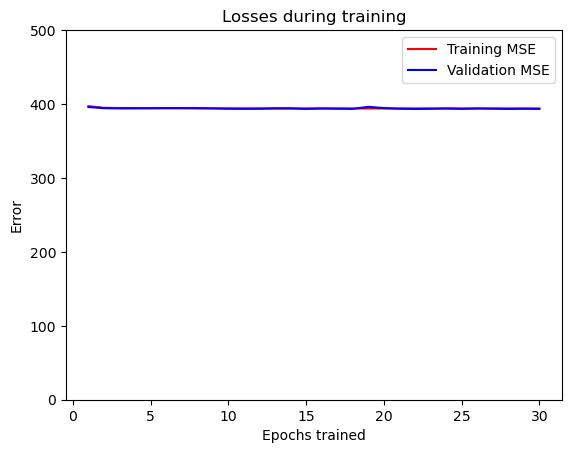

In [12]:
x = range(1, 31)

plt.plot(x, history.history["loss"], color="red", label="Training MSE")

plt.plot(x, history.history["val_loss"], color="blue", label="Validation MSE")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Epochs trained")
plt.ylabel("Error")
plt.ylim((0, 500))
plt.show()

In [ ]:
# keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [13]:
results = model.evaluate(i_test, t_test, batch_size=50)

print("RMSE:", np.sqrt(results[0]))

41647/41647 ━━━━━━━━━━━━━━━━━━━━ 19s 444us/step - loss: 395.2029 - mean_absolute_percentage_error: 713440.6250
RMSE: 19.857553946306396
